## Validação cruzada: múltliplos treinamentos e testes

### ETAPA 1: Implementacão da validação cruzada

Após fazer o tunning dos modelos (script Tunning) e descobrirmos os melhores valores de parâmetros para cada um deles, irei realizar a validação cruzada usando esses melhores modelos. A validação cruzada cria diferentes combinações dos dados para compor múltiplas bases de treino e teste, realizando essas etapas diversas vezes para um mesmo algoritmo.  Isso ajuda a diminui as chances de termos algum efeito aleatório indesejado quando realizamos apenas um treino/teste. E também permite que façamos uma análise estatística mais rigorosa para decidir se um modelo performa melhor que o outro, baseado em testes de hipótese com as médias das métricas de performance obtidas nos repetidos treinos e testes.

Para cada modelo irei fazer 30 iterações, e a cada iteração dividiremos aleatoriamente a base de dados  em 10 partes:  9 para treino e 1 para teste (parâmetro "n_splits" do objeto K-fold ). A cada nova iteração setamos um valor diferente para a semente que gera o sorteio da divisão da base através do parâmetro "random_state". Assim garantimos novas combinações dos subcobjuntos de treino e teste a cada rodada. 

No fim devemos ter 30 listas (referentes ao número de iterações do laço for) com 10 valores da métrica de desempenho (acurácia) avaliada para cada modelo (10 diferentes combinações das bases treino e teste). E então iremos sumarizar esses 10 resultados em uma média aritmética para realizar a análise dos resultados na próxima etapa através de testes de hipóteses. Assim ganharemos mais confiança sobre quais modelos desempenham melhor. Vamos começar: 


___



In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import pandas as pd
import numpy as np
import pickle as pickle
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import shapiro
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import MultiComparison
import warnings

In [3]:
# Variáveis globais:
n_iterations = 30
n_splits = 10

Antes disso: concatenar as bases que estão salvas separadamente em treino e teste:

In [4]:
with open("../data/credit.pkl", "rb") as f:
    X_credit_train, y_credit_train, X_credit_test, y_credit_test = pickle.load(f)
    
X_credit = np.concatenate((X_credit_train, X_credit_test), axis=0)
y_credit = np.concatenate((y_credit_train,y_credit_test),axis=0)
X_credit.shape, y_credit.shape

((2000, 3), (2000,))

E declarar a função que retorna as médias dos resultados de cada modelo, para reaproveitarmos o código com os diferentes algoritmos:

In [5]:
def returnCrossValidationResults(model, result_list):
    for i in range(n_iterations):
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=i)
        scores = cross_val_score(model, X_credit, y_credit, cv=kfold)
        result_list.append(round(scores.mean(),4))

### Naive-Bayes

In [6]:
results_naive_bayes = []
model_naive_bayes = GaussianNB()
returnCrossValidationResults(model_naive_bayes, results_naive_bayes)

### Árvore de Decisão

In [7]:
results_tree = []
model_tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=1, min_samples_split=5, splitter='best')
returnCrossValidationResults(model_tree, results_tree)

### Random Forest


In [8]:
results_random_forest = []
model_random_forest = RandomForestClassifier(criterion = 'entropy', min_samples_leaf = 1, min_samples_split=5, n_estimators = 10)
returnCrossValidationResults(model_random_forest, results_random_forest)

### KNN

In [9]:
results_knn = []
model_knn = KNeighborsClassifier(n_neighbors=5, p=1)
returnCrossValidationResults(model_knn, results_knn)

### Regressão Logística


In [10]:
results_log_reg = []
model_log_reg = LogisticRegression(C = 1.0, solver = 'lbfgs', tol = 0.0001)
returnCrossValidationResults(model_log_reg, results_log_reg)

----

### ETAPA 2: Análise dos resultados

Primeiro, vamos consolidar os resultados em um dataframe para facilitar a manipulação e visualização:

In [11]:
results = pd.DataFrame({
    "naive-bayes": results_naive_bayes,
    "tree_decision": results_tree,
    "random_forest": results_random_forest,
    "knn": results_knn,
    "regression_log": results_log_reg
})

In [12]:
results.describe()

,naive-bayes,tree_decision,random_forest,knn,regression_log
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.925333,0.988133,0.983200,0.979517,0.946950
std,0.000922,0.001548,0.002003,0.001653,0.000941
min,0.922500,0.984500,0.979500,0.975500,0.945000
25%,0.925000,0.987125,0.982000,0.978500,0.946500
50%,0.925500,0.988250,0.983000,0.979500,0.947000
75%,0.926000,0.989000,0.984500,0.980500,0.947500
max,0.927000,0.991000,0.987000,0.982500,0.949000


In [13]:
results.mean()

naive-bayes       0.925333
tree_decision     0.988133
random_forest     0.983200
knn               0.979517
regression_log    0.946950
dtype: float64

Aparentemente o algoritmo de árvore de decisão foi o melhor (maior média de acurácia). Porém, esse resultado pode ter sido obtido por acaso. O que faremos agora é aplicar um teste de hipóteses baseado na média (teste paramétrico) para checar se os resultados dos modelos diferem estatisticamente entre si. Ou seja, para avaliar se um modelo é efetivamente melhor ou pior do que outro através de múltiplos experimentos.

Antes de prosseguir com a análise dos resultados, há um porém: os testes são baseados na média das métricas, e por isso é necessário validar a premissa de que os dados apresentam distribuição normal (hipótese nula do teste de normalidade). Para isso é possível usar o teste de Shapiro-Wilks (https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test). 

Assumindo um nível de significância de 5%, para valores de p > 0.05  aceitamos a hipótese nula. Ou seja, assumo que distribuição dos dados é normal e que posso prosseguir com a aplicação dos testes de média na análise dos resultados. 


Vamos checar a premissa da normalidade então:

In [14]:
shapiro(results_naive_bayes)[1], shapiro(results_tree)[1], shapiro(results_random_forest)[1], shapiro(results_knn)[1], shapiro(results_log_reg)[1]

(0.02320495992898941,
 0.5915992856025696,
 0.7082595229148865,
 0.8722361326217651,
 0.3575483560562134)

Vemos que apenas os resultados do modelo de regressão logística não são normais. 

Vamos checar a distribuição dos dados também de forma visual, através de um gráfico:

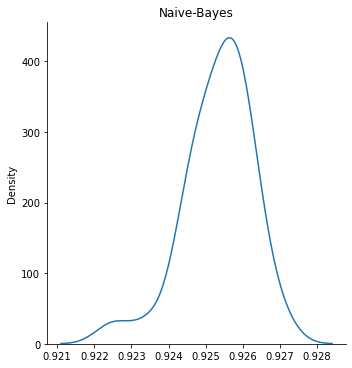

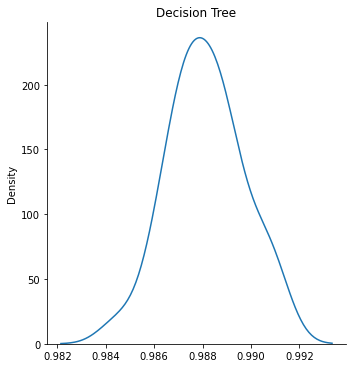

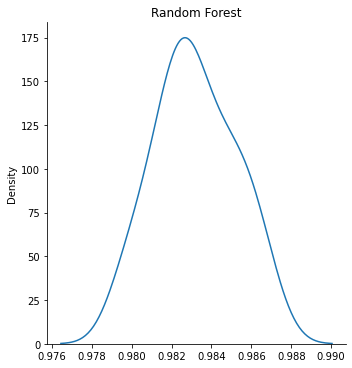

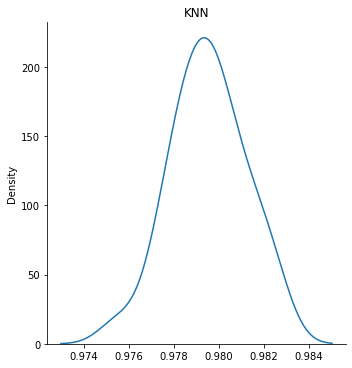

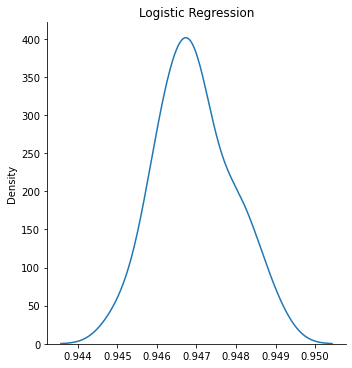

In [15]:
sns.displot(results_naive_bayes, kind='kde').set(title='Naive-Bayes')
sns.displot(results_tree, kind='kde').set(title='Decision Tree')
sns.displot(results_random_forest, kind='kde').set(title='Random Forest')
sns.displot(results_knn, kind='kde').set(title='KNN')
sns.displot(results_log_reg, kind='kde').set(title='Logistic Regression')

Agora, realizando o teste de média entre os resultados: vamos utilizar a ANOVA, uma análise que serve para comparar a variação de uma métrica quantitativa (acurácia dos modelos) entre 3 ou mais grupos (os algoritmos). Considerarei a hipótese nula (H0) aquela que diz que os modelos são iguais e também o nível de significância de 5%, como no teste de normalidade:

In [16]:
alpha = 0.05
_, p = f_oneway(results_naive_bayes,results_tree, results_random_forest, results_knn, results_log_reg)
print ("H0 rejeitada. Resultados são diferentes." if p < alpha else "H0 aceita. Resultados são iguais.")

H0 rejeitada. Resultados são diferentes.


Agora que já sabemos que os resultados são estatisticamente diferentes, precisamos investigar quais pares de resultados diferem entre si. Assim podemos descobrir, por exemplo, se os resultados do algoritmo de Árvore de Decisão (maior média de acurácia) diferem estatisticamente dos resultados do segundo colocado, o algoritmo Random Forest. Para isso podemos usar a análise de Tukey como teste a posteriori:

In [17]:
# consolidando base de dados para o teste:
all_results = np.concatenate([results_naive_bayes,results_tree, results_random_forest, results_knn, results_log_reg])
results_df = pd.DataFrame({'accuracy': all_results, 'model': np.array(0)})
results_df.loc[0:29,"model"] = "naive bayes"
results_df.loc[30:59,"model"] = "tree_decision"
results_df.loc[60:89,"model"] = "random_forest"
results_df.loc[90: 119,"model"] = "knn"
results_df.loc[120: 149,"model"] = "log regression"

In [18]:
results_df.head()

,accuracy,model
0,0.9260,naive bayes
1,0.9255,naive bayes
2,0.9270,naive bayes
3,0.9260,naive bayes
4,0.9225,naive bayes


In [19]:
results_df["model"].value_counts()

random_forest     30
knn               30
naive bayes       30
tree_decision     30
log regression    30
Name: model, dtype: int64

Agora sim, realizando o teste de Tukey:

In [20]:
multi_comparasion_obj = MultiComparison(results_df["accuracy"], results_df["model"])
tukey_test_result = multi_comparasion_obj.tukeyhsd()
print(tukey_test_result)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj  lower   upper  reject
-------------------------------------------------------------------
           knn log regression  -0.0326 0.001 -0.0336 -0.0315   True
           knn    naive bayes  -0.0542 0.001 -0.0552 -0.0531   True
           knn  random_forest   0.0037 0.001  0.0026  0.0047   True
           knn  tree_decision   0.0086 0.001  0.0076  0.0097   True
log regression    naive bayes  -0.0216 0.001 -0.0227 -0.0206   True
log regression  random_forest   0.0363 0.001  0.0352  0.0373   True
log regression  tree_decision   0.0412 0.001  0.0401  0.0422   True
   naive bayes  random_forest   0.0579 0.001  0.0568  0.0589   True
   naive bayes  tree_decision   0.0628 0.001  0.0617  0.0639   True
 random_forest  tree_decision   0.0049 0.001  0.0039   0.006   True
-------------------------------------------------------------------


Vemos pelo teste que todos os pares de grupos/algoritmos diferem entre si em relação aos valores de acurácia (p-value < 0.05). Vamos checar o rank da média dessa métrica dos algoritmos:

In [21]:
results.mean().sort_values(ascending=False)

tree_decision     0.988133
random_forest     0.983200
knn               0.979517
regression_log    0.946950
naive-bayes       0.925333
dtype: float64

De forma mais visual:

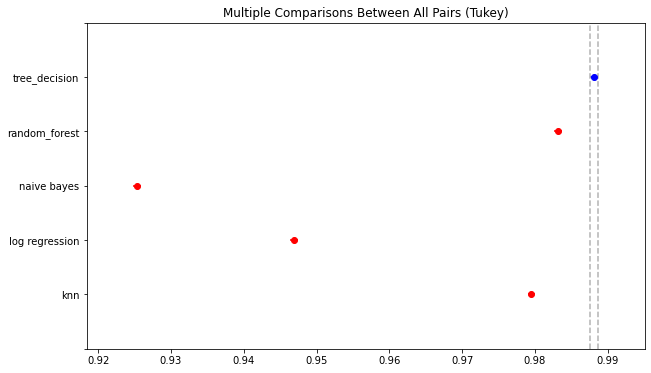

In [22]:
warnings.filterwarnings('ignore')
tukey_test_result.plot_simultaneous(comparison_name="tree_decision");

Dessa forma podemos concluir que os algoritmos tiveram desempenhos diferentes e que o modelo "Tree Decision" teve a maior acurácia, em média, quando comparado com os outros. Portanto, se eu precisasse colocar algum desses modelos em produção para que uma empresa (como um banco) possa prever o pagamento de empréstimos pelos clientes, esse seria o modelo escolhido por mim!